In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Question 4

**[80 points]** Recalling the presentation of FMM in 2D with the potential due to a charge as $\log(z)$, consider 3 clouds of points denoted as $S_1$ ,$S_2$ and $T_1$. The center of cloud $S_1$ in the complex plane is $−p$, the center for cloud $S_2$ is $p \, e^{-i \tfrac{\pi}{4}}$ and the center for $T_1$ is $p$, where $i^2=-1$. All clouds have $N$ points uniformly distributed within a circle of radius $r$ and the charges of $S_1$ and $S_2$ are uniformly distributed following uniform distribution $U(2,10)$.

---

**a)** Propose a numerical algorithm to perform a *fast* sum to evaluate the potential due the source points in cloud $S_1$ over the target points $T_1$ by means of a multipole expansion. The mathematical description of the source points can be written as:
$$
s_1(z) = \sum_{i=1}^N q_i \log(z-z_i).
$$

---

Asumiendo que las nubes no se tocan (para este ítem eso significa que $r < q$):

Se propone utilizar FFM colocando como orígen el centro de $S_1$. El potencial este sistema de coordenadas está entonces dado por:
$$
\phi(x) = \sum_{i=1}^{N} q_i \log(x-z_i') \,,
$$
donde $z_i' = z_i+p$.

Usando FFM este campo es equivalente a:
$$
\phi(x) \approx Q \log(x) + \sum_{k=1}^{P} \frac{a_k}{x^k} \,,
$$
donde
$$
Q = \sum_{i=1}^{N} q_i \qquad \qquad
a_k = \sum_{i=1}^{N} \frac{-q_i (z_i')^{k}}{k} \,.
$$
La aproximación es exacta cuando $P \rightarrow \infty$, pero se pueden calcular menos iteraciones.

Precomputando los $a_k$, que no dependen de $x$, sólo se necesitarían realizar $O(P)$ operaciones por cada uno de los $N$ puntos que se quieren evaluar en el campo. La complejidad final es entonces $O(N P)$, mejor que la $O(N^2)$ original.

Para obtener $s_i(z)$ se hace:
$$
s_i(z) = \phi(z+p)
$$

---

**b)** Implement in a Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as $N$ increases, show how the error changes and test how the approximation depends on $p$ and $r$.

*Hint: I suggest to keep $r = 1$ and only vary $p$ conveniently. Notice that if $p$ is large enough, the approximation should be good so it would be interesting to see what happens when the clouds approach each other!*

*Hint 2: An error vs computation time plot would be good.*

---

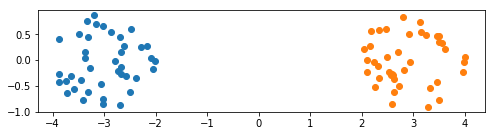

In [5]:
def point_cloud(N,rad=1):
    angles = 2*np.pi*np.random.random(N)
    poss = np.random.random(N)**0.5*rad*np.exp(1j*angles)
    return poss

def charges(N,minc,maxc):
    return minc+np.random.random(N)*(maxc-minc)

# Generate and plot points for a given p and N
p = 3
N = 40
pts_s1 = point_cloud(N)-p
pts_t = point_cloud(N)+p
pts_s1_q = charges(N,2,10)

plt.figure(figsize=(8,6))
plt.plot(np.real(pts_s1),np.imag(pts_s1),'o')
plt.plot(np.real(pts_t),np.imag(pts_t),'o')
plt.axis('scaled')
plt.show()

In [6]:
# Compute the potential using the direct method
def direct_potential(srcs,srcs_q,trgts):
    deltas = np.expand_dims(trgts,-1)-srcs # matrix of distances
    terms = np.log(deltas+0j)*srcs_q 
    fields = np.sum(terms,axis=-1)
    return fields

# Compute the potential using fast multipole method
def fmm_potential(srcs,srcs_q,trgts,p=6):
    # sum of chargues
    qq = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # compute the z^k for each target:
    zk = np.expand_dims(trgts,-1)**np.arange(1,p+1)
    # get the fields for each target
    zs = qq*np.log(trgts+0j) + np.sum(aks/zk,axis=1)
    return zs

In [67]:
# Compute the local taylor series coefficients for targets near the origin,
# where z0 is the center of the sources
def local_taylor_series_coefs(z0,srcs,srcs_q,p=6,q=6):
    # relativize sources to their center
    srcs -= z0
    # sum of chargues
    a0 = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # ---
    # compute the z0^k 's:
    z0k_p = z0**np.arange(1,p+1)
    z0k_q = z0**np.arange(1,q+1)
    # binomial coefficients for b_l. NOTE: this could be optimized using dynamic prog.
    binoms = [[binom(l+k-1,k-1) for k in range(1,p+1)] for l in range(1,q+1)]
    binoms = np.array(binoms)
    # compute b_l's
    b0 = np.sum(aks/z0k_p*(-1)**np.arange(1,p+1))+a0*np.log(-z0)
    bls = (1/z0k_q)*np.sum(aks/z0k_p*binoms*(-1)**np.arange(1,p+1),axis=1)
    bls -= a0/(np.arange(1,q+1)*z0k_q)
    return np.concatenate( ([b0],bls) )
    
def eval_coefs(coefs,trgts):
    # compute the z^k for each target:
    qp1 = np.shape(coefs)[0]
    zk = np.expand_dims(trgts,-1)**np.arange(qp1)
    # multiply the coefficients and sum
    return np.sum(zk*coefs,axis=1)

In [71]:
p = 5
N = 10
M = 15

cloud_s1 = point_cloud(N)
cloud_t = point_cloud(M)
pts_s1_q = charges(N,2,10)

pts_s1 = cloud_s1
pts_t =  cloud_t+2*p

a = direct_potential(pts_s1,pts_s1_q,pts_t)
b = fmm_potential(pts_s1,pts_s1_q,pts_t,4)

pts_s1 = cloud_s1-2*p
pts_t  = cloud_t
coefs = local_taylor_series_coefs(-2*p,pts_s1,pts_s1_q,4,5)
c = eval_coefs(coefs,pts_t)

print(np.real(a-b))
print(np.imag(a-b))
print(np.real(a-c))
print(np.imag(a-c))
# print(coefs)

[1.46456380e-05 1.93174761e-05 1.15004014e-05 1.95991444e-05
 1.78510010e-05 1.43891991e-05 1.35060285e-05 1.44307806e-05
 1.28784487e-05 1.16072701e-05 2.62565644e-05 1.65726876e-05
 1.23571698e-05 1.78462341e-05 1.50389173e-05]
[ 4.31529251e-06  9.31140521e-06  3.56633469e-06  6.92538593e-06
 -4.10276196e-07 -1.87852164e-06  4.44377866e-06  2.87344974e-06
  5.52658110e-06  3.85055437e-06 -1.35232502e-06  6.44868113e-06
 -4.83136015e-07 -1.59704467e-06 -1.07371350e-06]
[1.44741408e-05 1.68845805e-05 2.10574954e-05 1.92209573e-05
 1.78510844e-05 1.46031985e-05 1.35235544e-05 1.46111305e-05
 9.71946739e-06 2.03633174e-05 2.72445653e-05 1.69851983e-05
 1.30416119e-05 1.78585876e-05 1.51562427e-05]
[ 4.02953723e-06  7.99399724e-06  4.21650690e-06  6.83063358e-06
 -4.11264514e-07 -1.17769050e-06  3.05779234e-06  2.88797982e-06
  2.41557037e-06  1.57274683e-06  3.26740903e-07  6.62960016e-06
 -4.39683479e-06 -1.60916019e-06 -9.50131716e-07]


---

**c)** Propose a numerical algorithm to perform a fast sum to evaluate the potential due the source points in cloud $S_1$ and $S_2$ over the target points $T_1$ by means of going from two multipole expansion to a power series.

---

---

**d)** Implement in Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as N
increases. Also test how the approximation depends on ρ and r. Hint: Same hints from (b) are valid here.

---